In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt

In [3]:
# Goals of notebook: Generate A matrices with varying polar decomposition --> Plot the trajectories --> Calculate the LQG cost

In [4]:
def genA(theta, epsilon, delta):

    U = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    P = np.diag([1 - epsilon - delta, 1 - epsilon + delta]) 

    A = U @ P

    # Caley transformation to a continuous time dynamics matrix
    Ac = -1*(np.eye(2) - A) @ np.linalg.inv(np.eye(2) + A)

    return A, Ac   


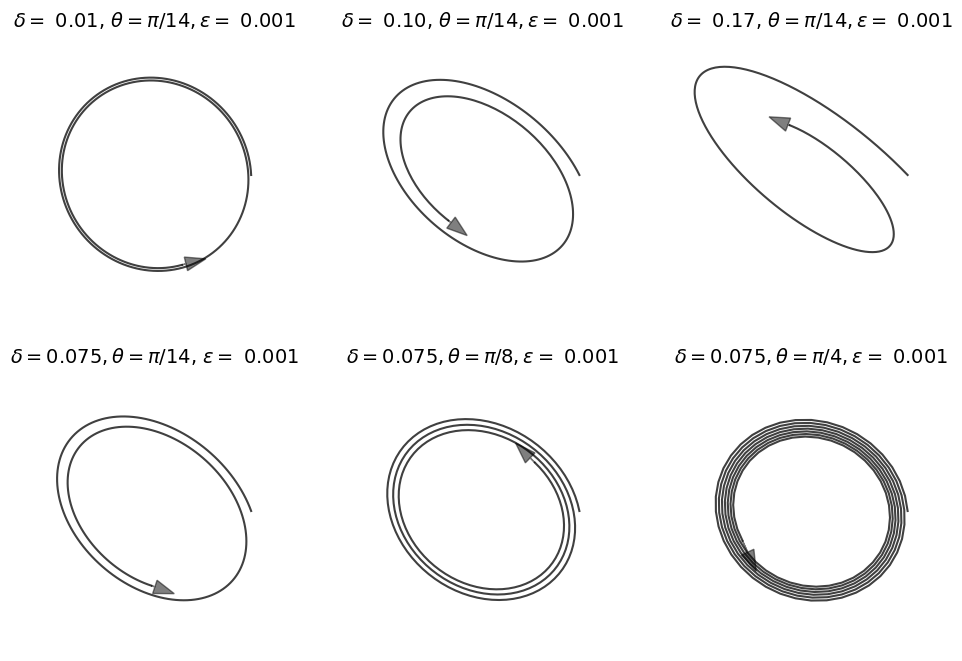

In [40]:
# Plot trajectories for fixed theta, varying delta, and then fixed delta, varying theta
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

th1 = np.pi/14
d1 = np.array([0.01, 0.1, 0.17])

d2 = 0.075
th2 = np.array([np.pi/14, np.pi/8, np.pi/4])
th2str = np.array([r'$\theta = \pi/14$, ', r'$\theta = \pi/8, $', r'$\theta = \pi/4, $'])


x0 = 1/np.sqrt(2) * np.array([1,0])

for i in range(3):

    # Map to continuous time and then sample the trajectory

    A = genA(th1, 1e-3, d1[i])[1]
    x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 250)])
    ax[0, i].plot(x[:, 0], x[:, 1], color='k', alpha=0.75)
    ax[0, i].arrow(x[-1, 0], x[-1, 1], 
            x[-1, 0] - x[-2, 0], x[-1, 1] - x[-2, 1], 
            head_width=0.1, color="k", alpha=0.5)

    ax[0, i].set_xlim([-1, 1])
    ax[0, i].set_ylim([-1, 1])

    ax[0, i].set_title(r"$\delta =$" + ' %.2f, ' % d1[i] +  r'$\theta = \pi/14, $' + r'$\epsilon =$' + ' %.3f' % 1e-3, fontsize=14)
    ax[0, i].axis('off')

    A = genA(th2[i], 1e-3, d2)[1]
    x = np.array([scipy.linalg.expm(A * k) @ x0 for k in np.linspace(0, 100, 250)])
    ax[1, i].plot(x[:, 0], x[:, 1], color='k', alpha=0.75)
    ax[1, i].arrow(x[-1, 0], x[-1, 1], 
            x[-1, 0] - x[-2, 0], x[-1, 1] - x[-2, 1], 
            head_width=0.1, color="k", alpha=0.5)

    ax[1, i].set_xlim([-1, 1])
    ax[1, i].set_ylim([-1, 1])

    ax[1, i].set_title(r"$\delta = 0.075, $" + th2str[i] + r'$\epsilon =$' + ' %.3f' % 1e-3, fontsize=14)
    ax[1, i].axis('off')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/2Dtraj_examples.pdf', bbox_inches='tight', pad_inches=0)


In [5]:
def LQG_score(A):
    P = scipy.linalg.solve_continuous_are(A, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    return np.trace(P @ Q)

def FCCA_score(A):
    # Normalize by variance 
    Pi = scipy.linalg.solve_continuous_lyapunov(A, -np.eye(A.shape[0]))

    # Calculate the ground truth LQG score
    Q = scipy.linalg.solve_continuous_are(A.T, np.eye(A.shape[0]), np.eye(A.shape[0]), np.eye(A.shape[0]))
    P = scipy.linalg.solve_continuous_are(A, Pi, np.linalg.matrix_power(Pi, -2), np.eye(A.shape[0]))
    return np.trace(P @ Q)

In [6]:
# Plot the spectrum of Ac as theta varies for a few value sof delta
theta = np.linspace(0, np.pi/3, 250)
delta = np.linspace(0, 0.2, 250)

iml = np.zeros((theta.size, len(delta)))
ssnorm = np.zeros((theta.size, len(delta)))
lqgscore = np.zeros((theta.size, len(delta)))
fccascore = np.zeros((theta.size, len(delta)))
pcascore = np.zeros((theta.size, len(delta)))

Ad = np.zeros((theta.size, len(delta)), dtype=object)
Ac_ = np.zeros((theta.size, len(delta)), dtype=object)

for i in range(theta.size):
    for j in range(len(delta)):
        A, Ac = genA(theta[i], 0.1, delta[j])
        Ad[i, j] = A
        Ac_[i, j] = Ac
        try:
            assert(np.max(np.real(np.linalg.eigvals(Ac))) < 0)
        except:
            print(delta[j])
            lqgscore[i, j] = np.nan
            fccascore[i, j] = np.nan
            pcascore[i, j] = np.nan
            continue            
        # iml[i, j] = np.imag(np.linalg.eigvals(Ac)[0])
        # ssnorm[i, j] = np.linalg.norm(Ac - 0.5 * (Ac - Ac.T))/np.linalg.norm(Ac)
        lqgscore[i, j] = LQG_score(Ac)
        fccascore[i, j] = FCCA_score(Ac)
        pcascore[i, j] = np.linalg.slogdet(scipy.linalg.solve_continuous_lyapunov(Ac, np.eye(Ac.shape[0])))[1]

0.10040160642570281
0.10120481927710843
0.10200803212851406
0.10281124497991968
0.10361445783132531
0.10441767068273093
0.10522088353413656
0.10602409638554218
0.10682730923694779
0.10763052208835341
0.10843373493975904
0.10923694779116466
0.11004016064257029
0.11084337349397591
0.11164658634538153
0.11244979919678716
0.11325301204819277
0.1140562248995984
0.11485943775100402
0.11566265060240964
0.11646586345381527
0.11726907630522089
0.11807228915662651
0.11887550200803214
0.11967871485943776
0.12048192771084337
0.121285140562249
0.12208835341365462
0.12289156626506025
0.12369477911646587
0.1244979919678715
0.12530120481927712
0.12610441767068273
0.12690763052208837
0.12771084337349398
0.12851405622489961
0.12931726907630522
0.13012048192771086
0.13092369477911647
0.13172690763052208
0.13253012048192772
0.13333333333333333
0.13413654618473897
0.13493975903614458
0.13574297188755022
0.13654618473895583
0.13734939759036144
0.13815261044176708
0.1389558232931727
0.13975903614457832
0.140

In [9]:
import matplotlib.patches as mpatches

In [10]:
from mpl_toolkits.axisartist.axislines import SubplotZero

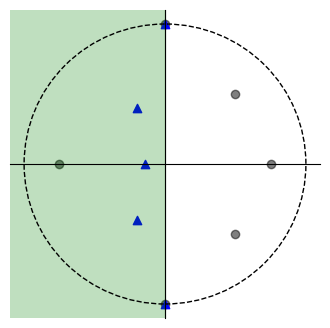

In [200]:
fig, ax = plt.subplots(figsize=(4, 4))

# Show example eigenvalues and how they get mapped via Cayley transform
e1 = np.array([-0.75, 0.75, 1j, -1j, 0.5 + 0.5j, 0.5 - 0.5j], dtype=complex)
e2 = -1 * (1 - e1)/(1 + e1)

ax.scatter(np.real(e1), np.imag(e1), color='k', alpha=0.5)
ax.scatter(np.real(e2), np.imag(e2), color='b', marker='^')

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax.set_xticks([])
ax.set_yticks([])

ax.fill_between([0, -2], [-2, -2], [2, 2], color='g', alpha=0.25)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax.add_patch(circle1)

fig.savefig('/home/akumar/nse/neural_control/figs/synth/eig_cayley.pdf', bbox_inches='tight', pad_inches=0)

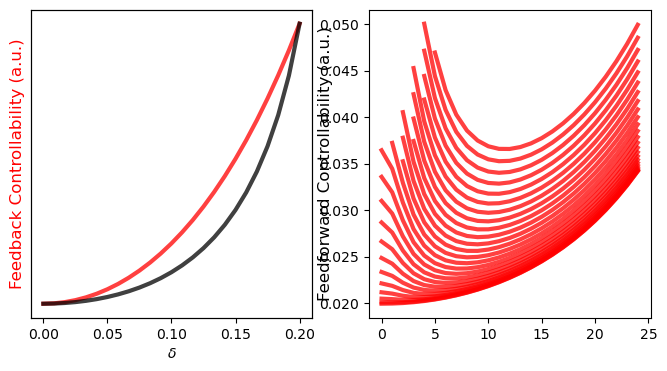

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax2 = ax[0].twinx()

ax[0].plot(delta, fccascore[5, :], color='r', linewidth=3, alpha=0.75)
ax2.plot(delta, pcascore[5, :], color='k', linewidth=3, alpha=0.75)

#red_patch = mpatches.Patch(color='red', label='FBC', alpha=0.75)
#black_patch = mpatches.Patch(color='black', label='FFC', alpha=0.75)
#ax.legend(handles = [red_patch, black_patch], loc = 'center left', fontsize=16)
ax[0].set_xlabel(r'$\delta$')
ax[0].set_ylabel('Feedback Controllability (a.u.)', color='red', fontsize=12)
ax2.set_ylabel('Feedforward Controllability (a.u.)', fontsize=12)
ax[0].set_yticks([])
ax2.set_yticks([])
#ax.set_xlabel(r'$||A - A_{ss}||/||A||$' + ' (a.u.)', fontsize=18)
#fig.savefig('rotational_dependence.pdf', bbox_inches='tight', pad_inches=0)

ax[1].plot(fccascore[:, ], color='r', linewidth=3, alpha=0.75)

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
import matplotlib

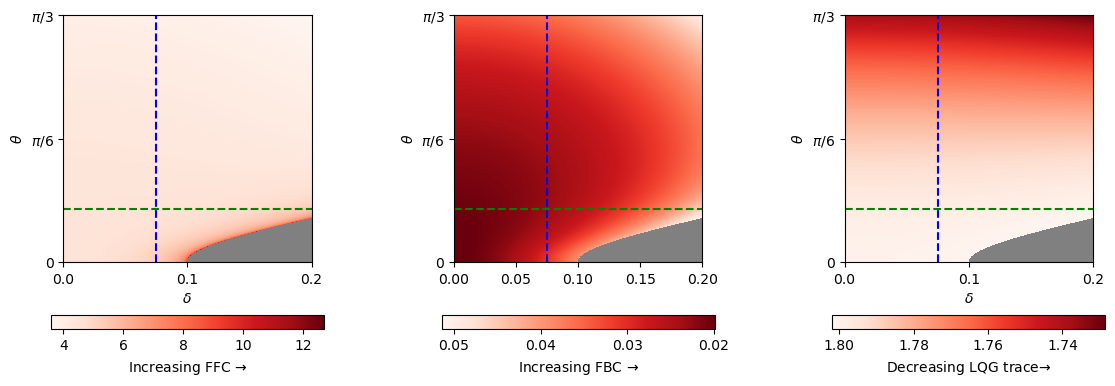

In [17]:
#fig, ax = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'projection':'3d'})
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# X, Y = np.meshgrid(theta, delta)
# ax[0].plot_surface(X, Y, fccascore)
# ax[1].plot_surface(X, Y, pcascore)
cmap = copy(matplotlib.cm.get_cmap('Reds'))
cmap.set_bad(color='grey')
epca = pcascore

im0 = ax[0].imshow(epca, vmin=np.nanmin(epca), vmax=np.nanmax(epca), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[0].invert_yaxis()
ax[0].set_aspect(0.19)
ax[0].set_yticks([0, np.pi/6, np.pi/3])
ax[0].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[0].set_ylabel(r'$\theta$')

ax[0].set_xticks([0., 0.1, 0.2])
ax[0].set_xlabel(r'$\delta$')
cb = fig.colorbar(im0, ax=ax[0], orientation='horizontal', shrink=0.75)
cb.ax.set_xlabel('Increasing FFC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
epca = pcascore
im1 = ax[1].imshow(fccascore, vmin=np.nanmin(fccascore), vmax=np.nanmax(fccascore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[1].invert_yaxis()
ax[1].set_aspect(0.19)
ax[1].set_yticks([0, np.pi/6, np.pi/3])
ax[1].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[1].set_ylabel(r'$\theta$')

cb = fig.colorbar(im1, ax=ax[1], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Increasing FBC ' + r'$\to$')


cmap = copy(matplotlib.cm.get_cmap('Reds_r'))
cmap.set_bad(color='grey')
im2 = ax[2].imshow(lqgscore, vmin=np.nanmin(lqgscore), vmax=np.nanmax(lqgscore), cmap=cmap, extent=[delta[0], delta[-1], theta[-1], theta[0]])
ax[2].invert_yaxis()
ax[2].set_aspect(0.19)

ax[2].set_yticks([0, np.pi/6, np.pi/3])
ax[2].set_yticklabels([0, r'$\pi/6$', r'$\pi/3$'])
ax[2].set_ylabel(r'$\theta$')
ax[2].set_xticks([0., 0.1, 0.2])
ax[2].set_xlabel(r'$\delta$')

# Add horizontal lines to cutout parts of parameter space
ax[0].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[0].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[1].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[1].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

ax[2].vlines(0.075, 0, np.pi/3, 'b', 'dashed')
ax[2].hlines(np.pi/14, 0, 0.2, 'g', 'dashed')

cb = fig.colorbar(im2, ax=ax[2], orientation='horizontal', shrink=0.75)
cb.ax.invert_xaxis()
cb.ax.set_xlabel('Decreasing LQG trace' + r'$\to$')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot1_lqg.pdf', bbox_inches='tight', pad_inches=0)

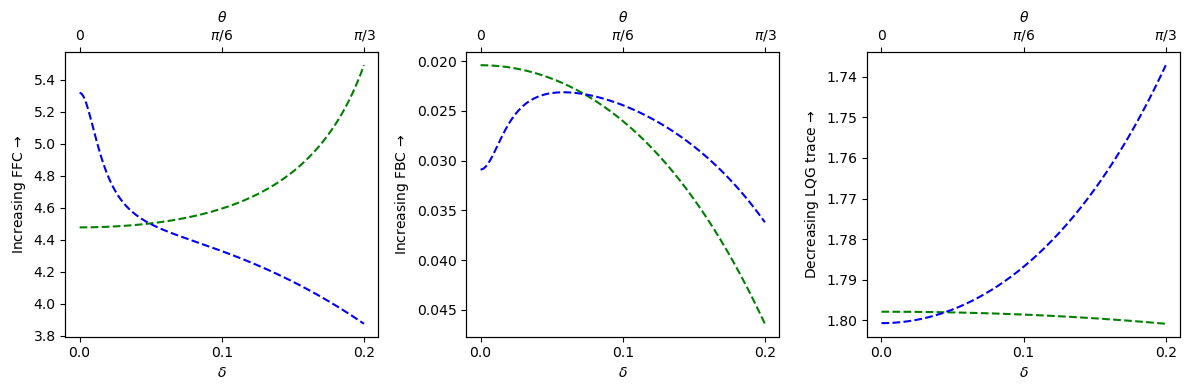

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Plot data along the green and blue contours
idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[0].plot(delta, pcascore[idx1, :], 'g', linestyle='dashed')
a = ax[0].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, pcascore[:, idx2], 'b', linestyle='dashed')
ax[0].set_ylabel('Increasing FFC ' + r'$\to$')
ax[0].set_xticks([0, 0.1, 0.2])
ax[0].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[1].plot(delta, fccascore[idx1, :], 'g', linestyle='dashed')
a = ax[1].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, fccascore[:, idx2], 'b', linestyle='dashed')
ax[1].invert_yaxis()
ax[1].set_ylabel('Increasing FBC ' + r'$\to$')
ax[1].set_xticks([0, 0.1, 0.2])
ax[1].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


idx1 = np.argmin(np.abs(theta - np.pi/14))
ax[2].plot(delta, lqgscore[idx1, :], 'g', linestyle='dashed')
a = ax[2].twiny()
idx2 = np.argmin(np.abs(delta - 0.075))
a.plot(theta, lqgscore[:, idx2], 'b', linestyle='dashed')
ax[2].invert_yaxis()
ax[2].set_ylabel('Decreasing LQG trace ' + r'$\to$')
ax[2].set_xticks([0, 0.1, 0.2])
ax[2].set_xlabel(r'$\delta$')

a.set_xticks([0, np.pi/6, np.pi/3])
a.set_xticklabels([0, r'$\pi/6$', r'$\pi/3$'])
a.set_xlabel(r'$\theta$')


fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/2Drot2_lqg.pdf', bbox_inches='tight', pad_inches=0)

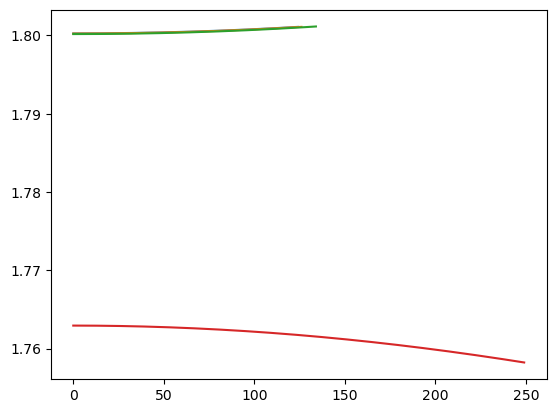

In [13]:
plt.plot(lqgscore[0, :])
plt.plot(lqgscore[5, :])
plt.plot(lqgscore[10, :])
plt.plot(lqgscore[200, :])